# House Sales in King Country, USA

Here [House Sales in King County, USA](https://www.kaggle.com/harlfoxem/housesalesprediction) dataset by [harlfoxem](https://www.kaggle.com/harlfoxem) is used to perform `EDA` on housing prices and creating `machine lerning model` to predict house prices.

**About data source**: This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between `May 2014 and May 2015`.

![](https://media.giphy.com/media/3o6Mba1qerHR51rl9C/giphy.gif)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

import xgboost

from scipy.stats import zscore, pearsonr

from joblib import dump

In [2]:
# Pandas config
def pandas_config():
    # display 10 rows and all the columns
    pd.set_option('display.max_rows', 10)
    pd.set_option('display.max_columns', None)
    
pandas_config()

In [3]:
# Loading the dataset
file_path = '/kaggle/input/housesalesprediction/kc_house_data.csv'
df = pd.read_csv(file_path)
df.sample(5)

id             date      price  bedrooms  bathrooms  \
12123  2141330700  20140522T000000   555000.0         4       2.25   
16844  8823900290  20150317T000000  1400000.0         9       4.00   
2372   9371700125  20140528T000000   254000.0         2       1.00   
12608  3812400455  20141104T000000   291000.0         7       1.00   
6157   3629980440  20150428T000000   742500.0         4       2.50   

       sqft_living  sqft_lot  floors  waterfront  view  condition  grade  \
12123         2350      8140     1.0           0     0          4      8   
16844         4620      5508     2.5           0     0          3     11   
2372          1060      8187     1.0           0     0          4      6   
12608         2350      8636     1.0           0     0          3      7   
6157          2620      4400     2.0           0     0          3      9   

       sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat  \
12123        1430            920      1977             0    98006  47.5579   
16844        3870            750      1915             0    98105  47.6684   
2372         1060              0      1952             0    98133  47.7508   
12608        1550            800      1962             0    98118  47.5432   
6157         2620              0      2004             0    98029  47.5524   

          long  sqft_living15  sqft_lot15  
12123 -122.129           2640        8700  
16844 -122.309           2710        4320  
2372  -122.349           1260        8188  
12608 -122.277           1500        7366  
6157  -121.991           2640        4554

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

No missing data

## Data preparation

In [5]:
# Drop df column
def drop_df_column(df, column_name, inplace=True):
    return df.drop([column_name], axis='columns', inplace=inplace)

In [6]:
drop_df_column(df, 'id')

In [7]:
print(df.select_dtypes('object').columns.tolist())
df.drop(['date'], axis='columns', inplace=True)

['date']


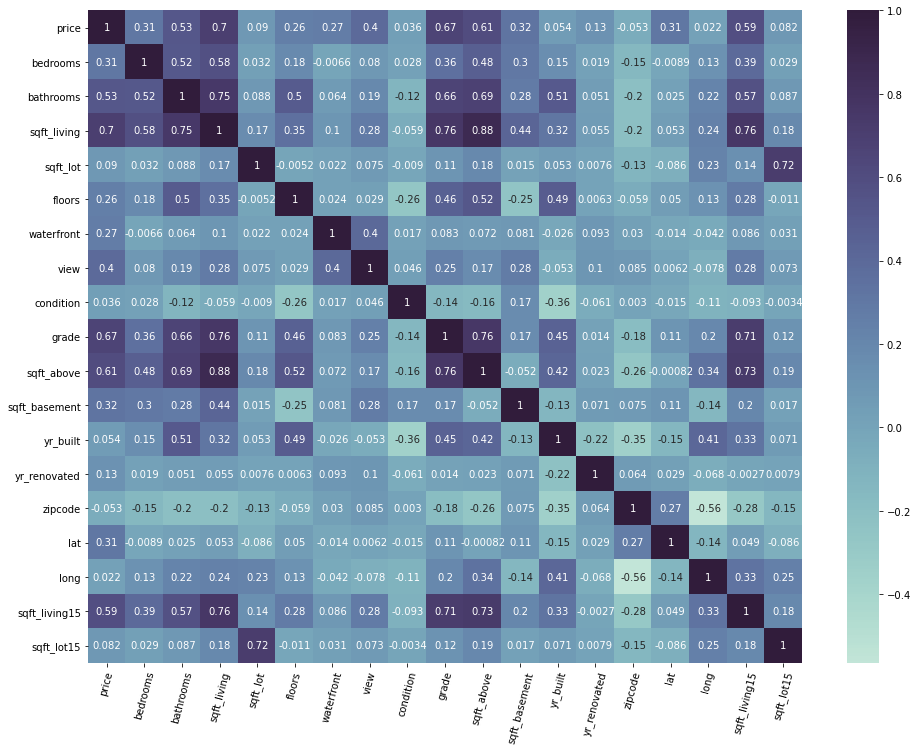

In [8]:
def plot_corr(df, figsize=(16, 12)):
    # the `corr` method uses pearson correaltion
    corr = df.corr()
    
    _, ax = plt.subplots(1, 1, figsize=figsize)
    g = sns.heatmap(corr, ax=ax, annot=True, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))

    for _ax in g.get_xticklabels():
        _ax.set_rotation(75)
    
    
plot_corr(df)

In [9]:
# Get columns names in as sentence (instead of getting long list 
# of column names)
def get_column_names(df):
    for column_name in df.columns.tolist():
        print(f'{column_name} | ', end='')

In [10]:
get_column_names(df)

price | bedrooms | bathrooms | sqft_living | sqft_lot | floors | waterfront | view | condition | grade | sqft_above | sqft_basement | yr_built | yr_renovated | zipcode | lat | long | sqft_living15 | sqft_lot15 | 

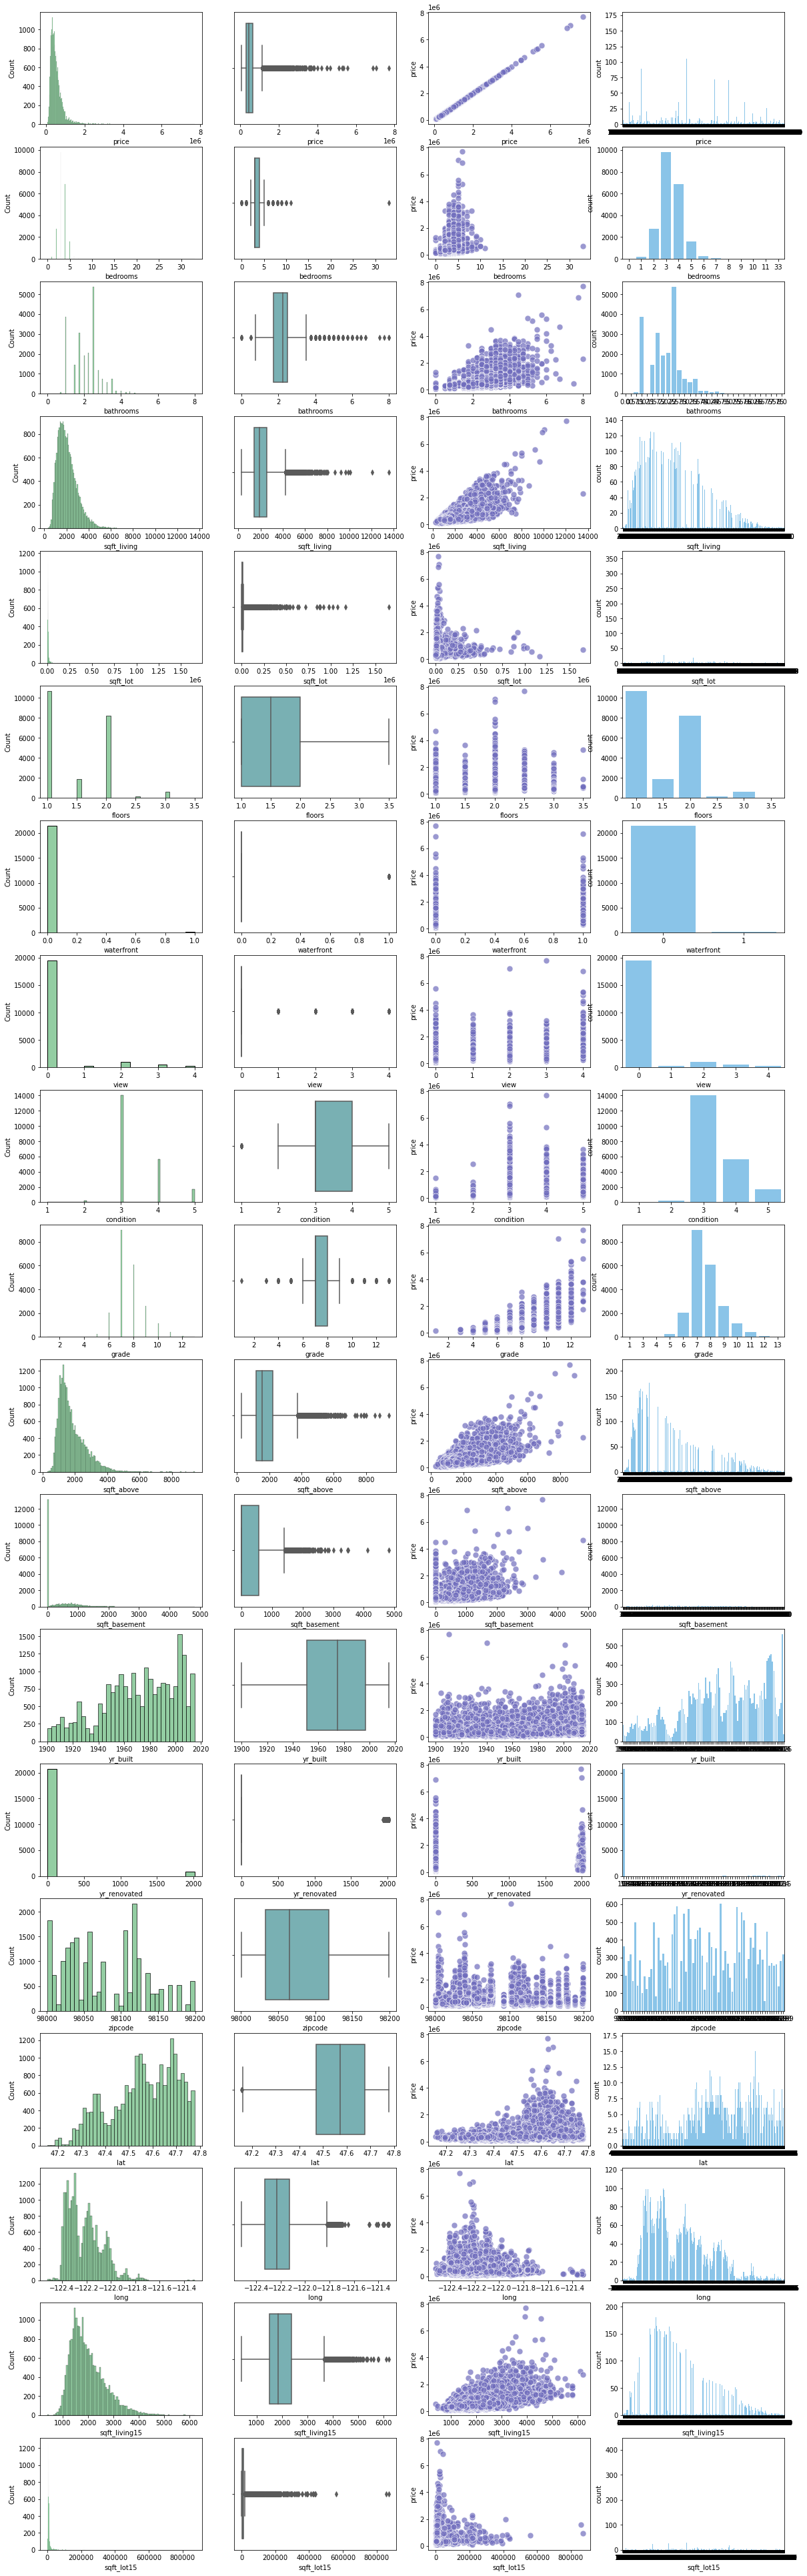

In [11]:
def plot_base_relation(df, figsize=(20, 200)):
    columns = df.columns.tolist()
    _, axs = plt.subplots(len(columns), 4, figsize=figsize)
    
    for idx, column in enumerate(columns):
        # To get distribution of data
        sns.histplot(
            x=df[column],
            kde=False,
            color='#65b87b', alpha=.7,
            ax=axs[idx][0]
        )

        # To get knowledge about outliers
        sns.boxplot(
            x=df[column],
            color='#6fb9bd',
            ax=axs[idx][1]
        )

        # To get its realtion with price
        sns.scatterplot(
            x=column, y='price', data=df,
            color='#706dbd', alpha=.7, s=80,
            ax=axs[idx][2]
        )
        
        # To get count plot for `column`
        sns.countplot(
            x=column, data=df,
            color='#42b0f5', alpha=.7,
            ax=axs[idx][3]
        )
        
        
plot_base_relation(df, figsize=(20, 70))

### Dealing with outliers

A lot of columns have issue of outliers. Using `IQR` & `Zscores` method to deal with it.

In [12]:
# Removing outliers using IQR method
def rm_outliers_in_col_using_iqr(df, col):
    # col here is df.column_name (or df[column_name])

    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1

    outliers_row_idx = col.loc[
        (col < (Q1 - 1.5 * IQR)) | (col > (Q3 + 1.5 * IQR))
    ].index.tolist()

    df = df.drop(outliers_row_idx, axis='rows')
    return (outliers_row_idx, df)


# Removing outliers using the Zscore method
def rm_outliers_in_col_using_zscore(df, col, column_name):
    # col here is df.column_name (or df[column_name])
    
    zscores_df = pd.DataFrame({
        f'{column_name}': col.to_numpy()
    }, df.index.tolist())
    
    zscores_df['zscores'] = zscores_df.apply(lambda x: zscore(x))
    outliers_row_idx = zscores_df[np.abs(zscores_df.zscores) > 3].index.tolist()

    df = df.drop(outliers_row_idx, axis='rows')
    return (outliers_row_idx, df)


# Remove outliers of a column using iqr & zscore methods
def remove_outliers_of_a_column(df, column_name):
    rm_idxs = []
    for _ in range(10):
        outliers_row_idx, df = rm_outliers_in_col_using_iqr(df, df[column_name])
        rm_idxs.extend(outliers_row_idx)
        
        outliers_row_idx, df = rm_outliers_in_col_using_zscore(df, df[column_name], column_name)
        rm_idxs.extend(outliers_row_idx)
    return rm_idxs, df


# Remove outliers of a df using iqr & zscore methods
def remove_outliers_of_df(df):
    rm_rows_idxs = []
    for column in df.columns.tolist():
        if column == 'price':
            # As we don't want to do anything with `price`
            continue
            
        rm_idxs, df = remove_outliers_of_a_column(df, column)
        rm_rows_idxs.extend(rm_idxs)
    return rm_rows_idxs, df

In [13]:
'''
    If you removed all the outliers in `continuous_df` then only 1/10th of the data is remaining.
    So instead of going through all the columns in df at once, we will go through each column at 
    a time and if the columns has 2% of outliners then we drop that column. Keeping the threshold 
    as 2% because if keep threshold higher then collectivetly a lot of rows will drop which in turn
    reduces our dataset 
    
    eg. if threshold is 20% then column1 (if there are 15% outliers then remove the rows) then 
    column2 (if there are 10% outliers then remove the rows) so in total we end up dropping 
    15% + 10% = 30% of our rows.
    
    So to avoid this we are keeping threshold as 2%
'''

# To do the above thing we can just modify the `remove_outliers_of_df` func
def remove_outliers_of_df_with_threshold(df, threshold=2):
    # `threshold` here is the percent above which the entire 
    # column will be dropped 

    rm_rows_idxs = []
    for column in df.columns.tolist():
        if column == 'price':
            # As we don't want to do anything with `price`
            continue
            
        rm_idxs, tmp_df = remove_outliers_of_a_column(df, column)

        if round(len(rm_idxs) / len(df), 2) * 100 > threshold:
            drop_df_column(df, column)
        else:
            df = tmp_df.copy()
            del tmp_df
            rm_rows_idxs.extend(rm_idxs)
   
    return rm_rows_idxs, df

In [14]:
print(f'Dataset size before removing outliers: {len(df)}')

with np.errstate(divide='ignore', invalid='ignore'):
    RM_ROWS_IDXS, df = remove_outliers_of_df_with_threshold(df, threshold=4)

print(f'Dataset size after removing outliers: {len(df)}')

Dataset size before removing outliers: 21613
Dataset size after removing outliers: 17762


In [15]:
print(f'{len(RM_ROWS_IDXS)} columns are dropped while removing outliers')

3851 columns are dropped while removing outliers


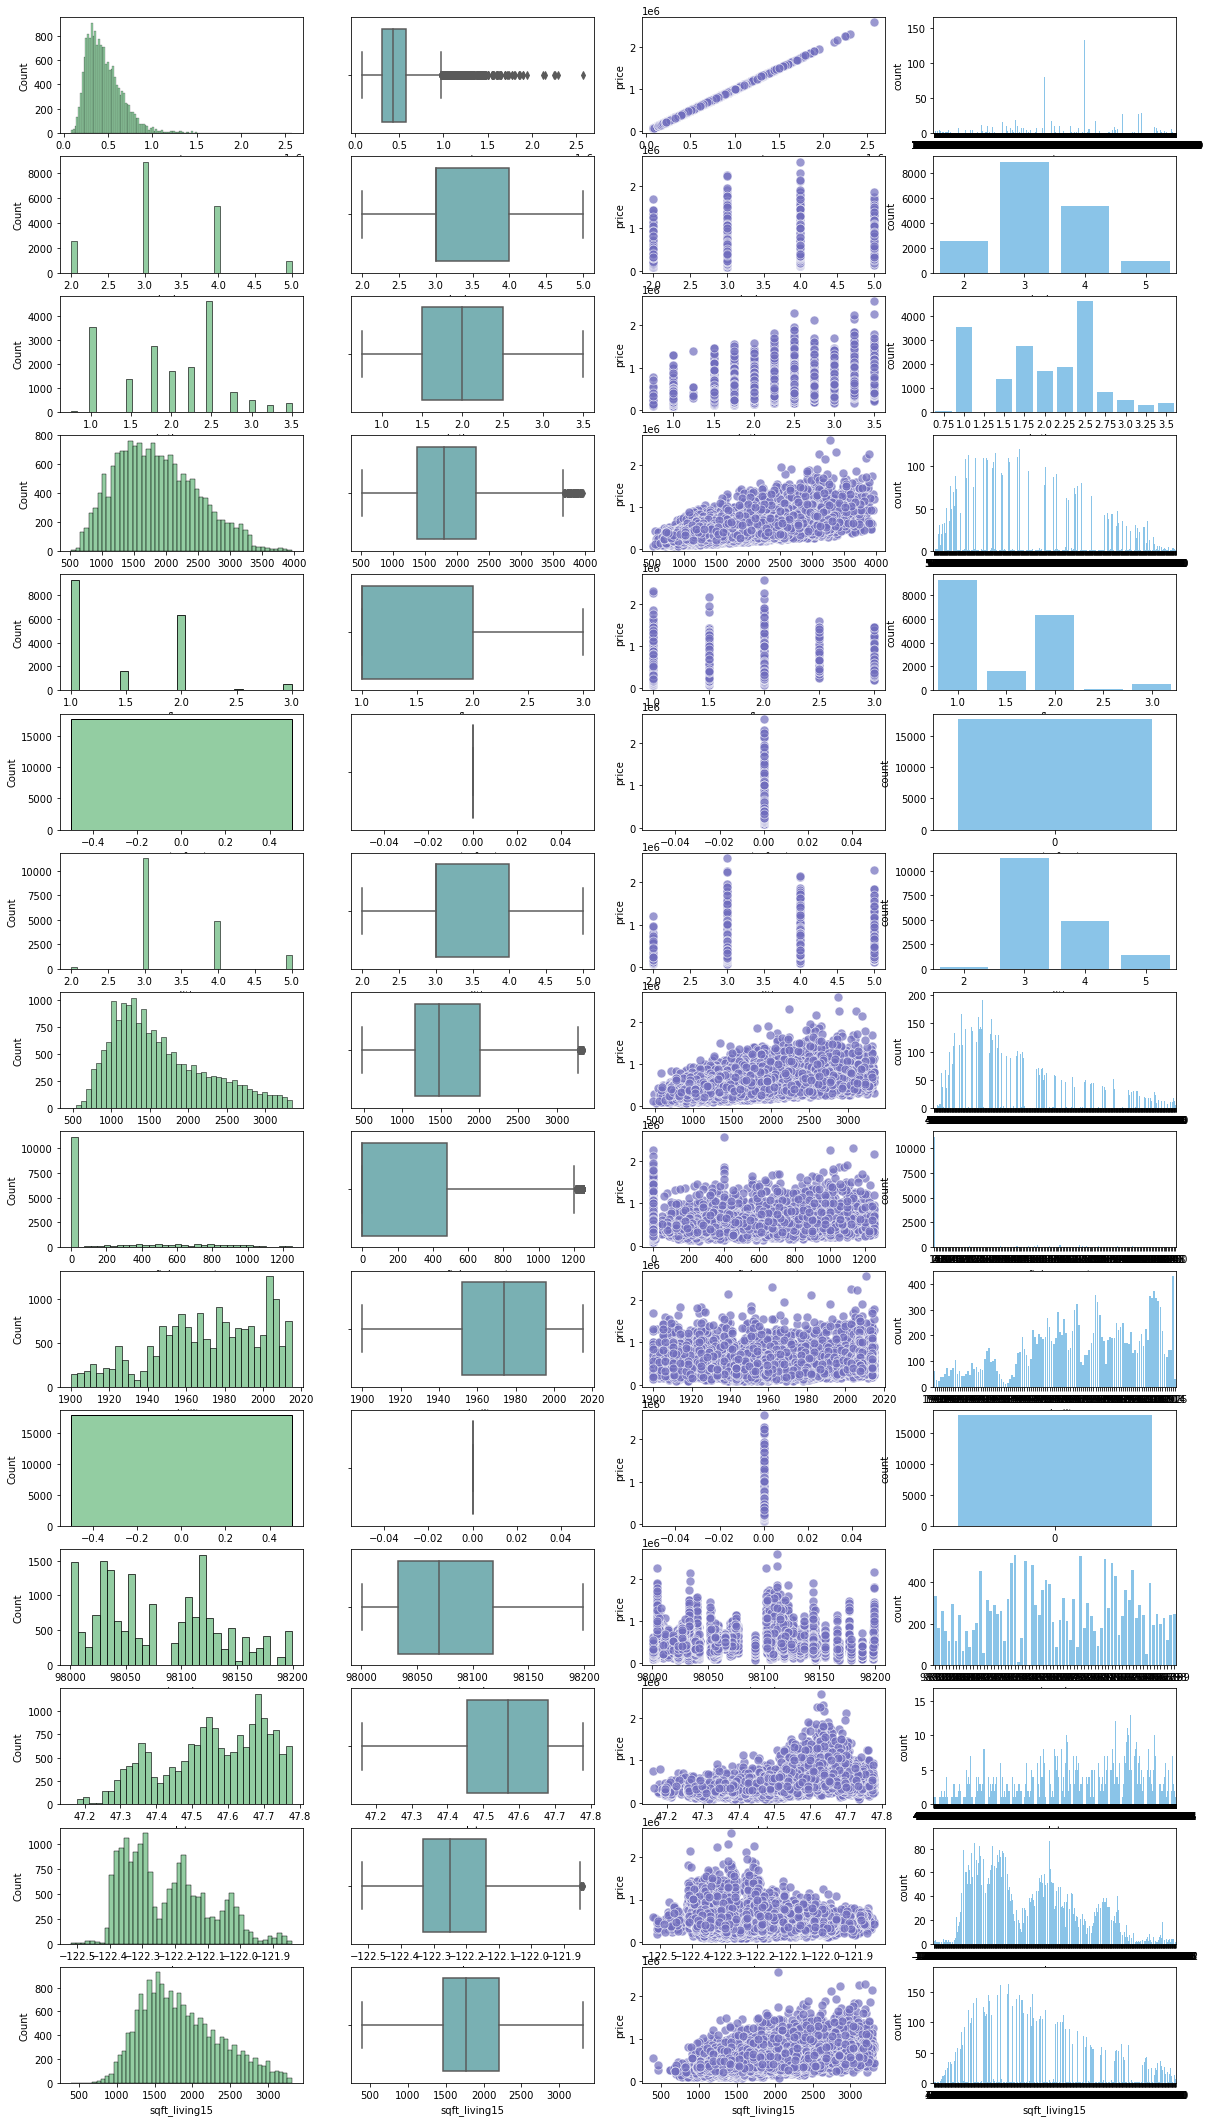

In [16]:
plot_base_relation(df, (20, 38))

In [17]:
# Remove columns which have only one unique value as they won't be useful
drop_df_column(df, 'waterfront')

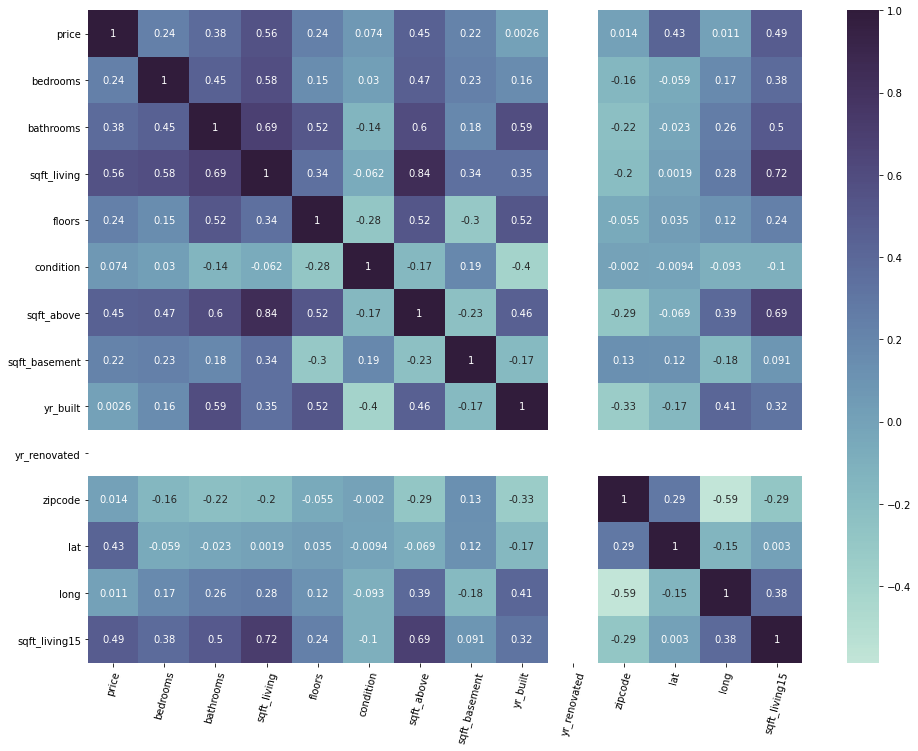

In [18]:
plot_corr(df)

In [19]:
drop_df_column(df, 'yr_renovated')
drop_df_column(df, 'zipcode')
drop_df_column(df, 'lat')
drop_df_column(df, 'long')

## Exploratory Data Analysis

In [20]:
df.head()

price  bedrooms  bathrooms  sqft_living  floors  condition  sqft_above  \
0  221900.0         3       1.00         1180     1.0          3        1180   
2  180000.0         2       1.00          770     1.0          3         770   
3  604000.0         4       3.00         1960     1.0          5        1050   
4  510000.0         3       2.00         1680     1.0          3        1680   
6  257500.0         3       2.25         1715     2.0          3        1715   

   sqft_basement  yr_built  sqft_living15  
0              0      1955           1340  
2              0      1933           2720  
3            910      1965           1360  
4              0      1987           1800  
6              0      1995           2238

In [21]:
def plot_scatterplot(x, y, ax=None):
    sns.scatterplot(
        x=x, y=y,
        color='#706dbd', alpha=.7, s=80,
        ax=ax
    )
    
    
def plot_boxplot(x, ax=None):
    sns.boxplot(x=x, color='#6fb9bd', ax=ax)
    
    
def plot_barplot(x, y, ax=None):
    sns.barplot(x=x, y=y, data=df, palette='rocket', ax=ax)

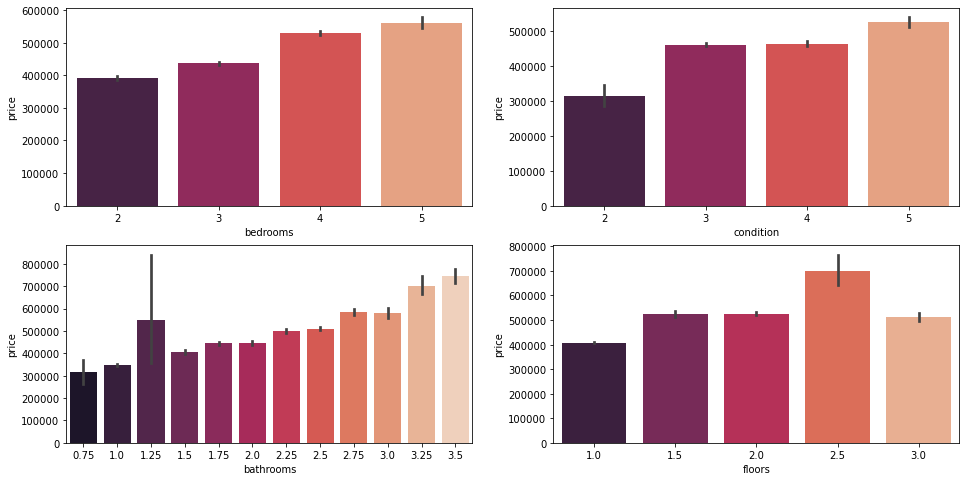

In [22]:
_, ax = plt.subplots(2, 2, figsize=(16, 8))


plot_barplot(df.bedrooms, df.price, ax=ax[0][0])
plot_barplot(df.condition, df.price, ax=ax[0][1])
plot_barplot(df.bathrooms, df.price, ax=ax[1][0])
plot_barplot(df.floors, df.price, ax=ax[1][1])

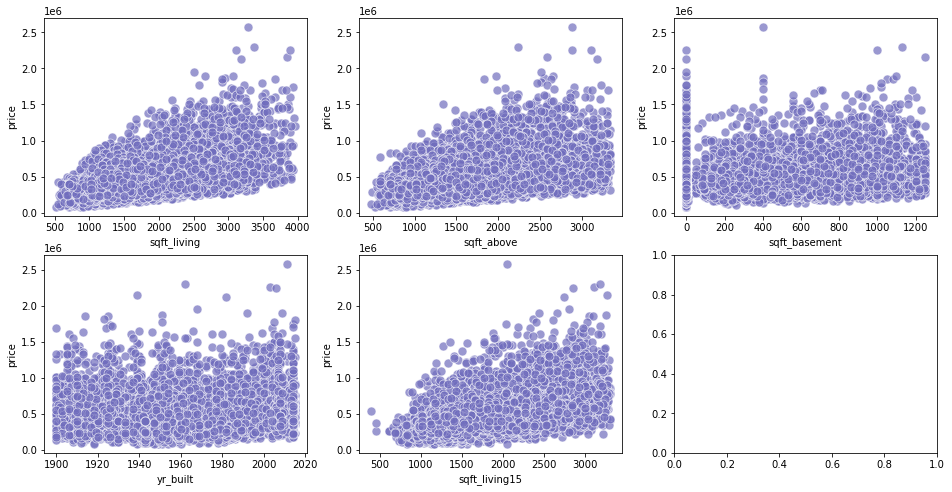

In [23]:
_, ax = plt.subplots(2, 3, figsize=(16, 8))

plot_scatterplot(df.sqft_living, df.price, ax=ax[0][0])
plot_scatterplot(df.sqft_above, df.price, ax=ax[0][1])
plot_scatterplot(df.sqft_basement, df.price, ax=ax[0][2])
plot_scatterplot(df.yr_built, df.price, ax=ax[1][0])
plot_scatterplot(df.sqft_living15, df.price, ax=ax[1][1])

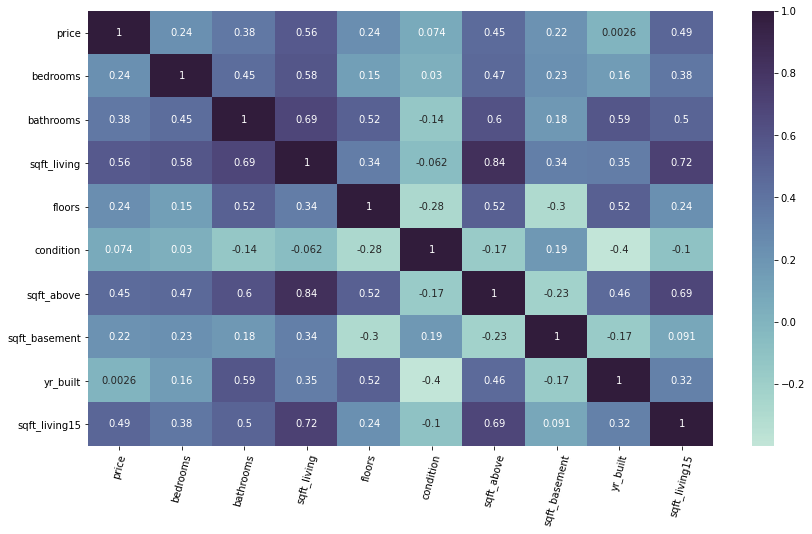

In [24]:
plot_corr(df, figsize=(14, 8))

`sqft_above` has strong positive correlation with `sqft_living` and moderate positive correlation with `sqft_living15` and `sqft_living` has positive correlation with `sqft_living15`. In short there is `multi-collinearity` issue here, so dropping any 2 columns out of 3. 

In [25]:
drop_df_column(df, 'sqft_above')
drop_df_column(df, 'sqft_living15')

(array([1880., 1900., 1920., 1940., 1960., 1980., 2000., 2020., 2040.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

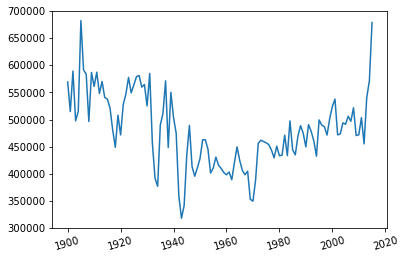

In [26]:
tmp_df = df[['yr_built', 'price']].sort_values(by=['yr_built'])

group = tmp_df.groupby(['yr_built'])['price'].mean()
avg_price_of_the_year = [avg_price for avg_price in group]

plt.plot(tmp_df.yr_built.unique(), avg_price_of_the_year, linestyle='solid')
plt.xticks(rotation=16)

## Modelling

In [27]:
# Scaling int & float dtype column
def standard_scaler(column):
    # Bumping up the ndim by np.newaxis as column.values is 1D & fit_transform needs 2D
    return StandardScaler().fit_transform(column.values[:, np.newaxis])


# Scaling all int & float dtype columns 
def scaling_df(df):
    # Selecting columns which have number dtype
    numbers_df = df.select_dtypes(include=[np.int64, np.float64])

    for column_name in numbers_df.columns.tolist():
        df[column_name] = standard_scaler(df[column_name])
    return df


# Scaling `continuous_df` for EDA 
scaling_df(df)

df.sample(5)

price  bedrooms  bathrooms  sqft_living    floors  condition  \
21582  0.114029 -0.342776   0.399156    -0.573529  0.983223  -0.658882   
12384  0.481629 -1.644547  -1.519704    -0.762665  0.983223  -0.658882   
16496  0.353768  0.958996   0.782928     0.734660  0.983223   0.877961   
4437  -0.077761 -1.644547   0.015384    -0.305587 -0.864526   0.877961   
9193   4.726144  0.958996   1.934244     2.531449  0.983223  -0.658882   

       sqft_basement  yr_built  
21582       0.122146  1.209612  
12384       0.178551 -0.591814  
16496      -0.667532  0.239613  
4437        1.616892 -1.804313  
9193        1.137445  1.174969

In [28]:
columns = df.columns.tolist()
columns.remove('price')

x = df[columns]
y = df['price']

In [29]:
# Splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=6)

In [30]:
# Cross validation

kf = KFold(n_splits=10)

score = cross_val_score(Ridge(), x_train, y_train, cv=kf)
print(score.mean())

pr = PolynomialFeatures(degree=4)
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.fit_transform(x_test)

score = cross_val_score(Ridge(), x_train_pr, y_train, cv=kf)
print(score.mean())

0.40043299950833655
0.4268088599676296


In [31]:
# Using XGBoost

xgb = xgboost.XGBRegressor()
try:
    xgb.fit(x_train_pr, y_train)
except KeyError:
    pass

## Evaluation

In [32]:
# Predictions
xgb_y_test_pred = xgb.predict(x_test_pr)

In [33]:
rms_error = mean_squared_error(y_test, xgb_y_test_pred, squared=False)
r2_score_value = r2_score(y_test, xgb_y_test_pred)

print(f"Root mean squared error: {rms_error}")
print(f"R2-score: {r2_score_value}")

Root mean squared error: 0.7790895301007307
R2-score: 0.3968816190272798


In [34]:
# Creating a pipeline

scaling = ('scale', StandardScaler())
ploy = ('ploy', PolynomialFeatures(degree=4))
model = ('model', xgboost.XGBRegressor())

# Steps in the pipeline
steps = [scaling, ploy, model]

pipe = Pipeline(steps=steps)

# Fiitting the model
model = pipe.fit(x_train, y_train)

# Out-Of-Sample Forecast
y_test_pred = model.predict(x_test)

# Evaluation
rms_error = mean_squared_error(y_test, y_test_pred, squared=False)
r2_score_value = r2_score(y_test, y_test_pred)

print(f"Root mean squared error: {rms_error}")
print(f"R2-score: {r2_score_value}")

Root mean squared error: 0.7755442290113983
R2-score: 0.4023581941171681


In [35]:
# Saving the model
dump(model, 'model.joblib')

['model.joblib']

## Visualizing our prediction against actual values

### Visualizing entire prediction vs actual value

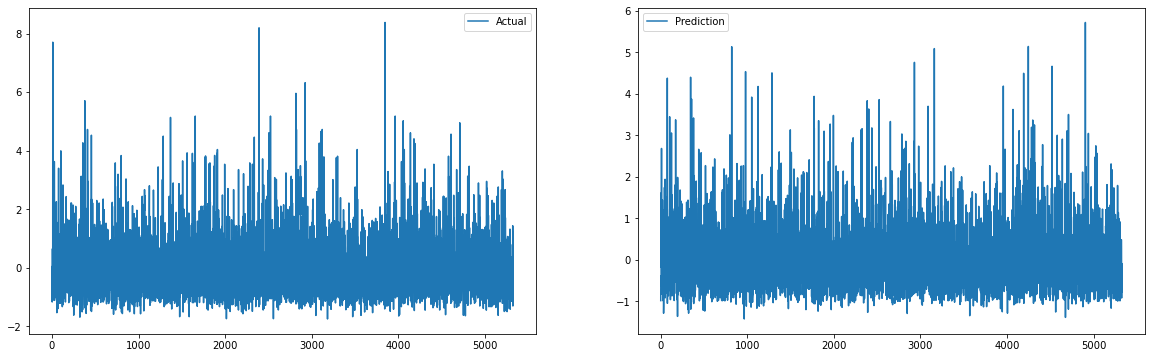

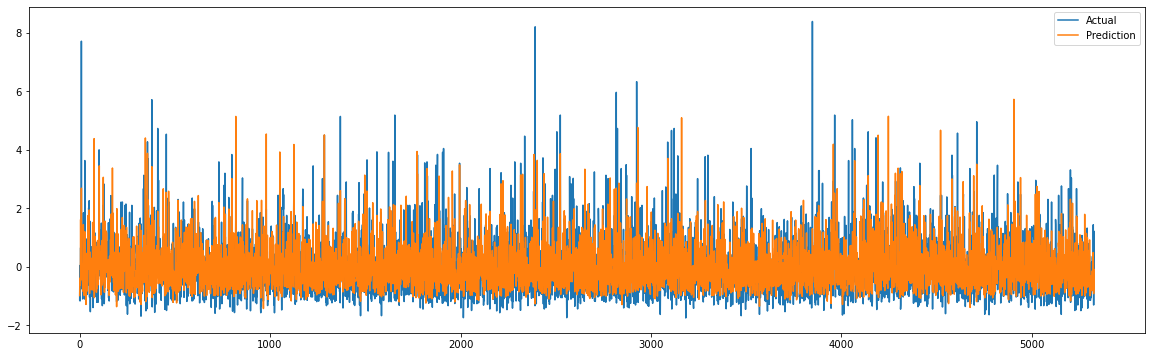

In [36]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

ax1.plot(np.arange(len(y_test)), y_test, label='Actual')
ax2.plot(np.arange(len(y_test_pred)), y_test_pred, label='Prediction')

ax1.legend()
ax2.legend()

f, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

ax3.plot(np.arange(len(y_test)), y_test, label='Actual')
ax3.plot(np.arange(len(y_test_pred)), y_test_pred, label='Prediction')

ax3.legend()

### Visualizing prediction vs actual values in interval of 100

In [37]:
def plot_result(start, end):
    f, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(13, 5))

    ax3.plot(np.arange(len(y_test[start:end+1])), y_test[start:end+1], label='Actual')
    ax3.plot(np.arange(len(y_test_pred[start:end+1])), y_test_pred[start:end+1], label='Prediction')

    ax3.set_title(f'{start} - {end}')
    ax3.legend()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


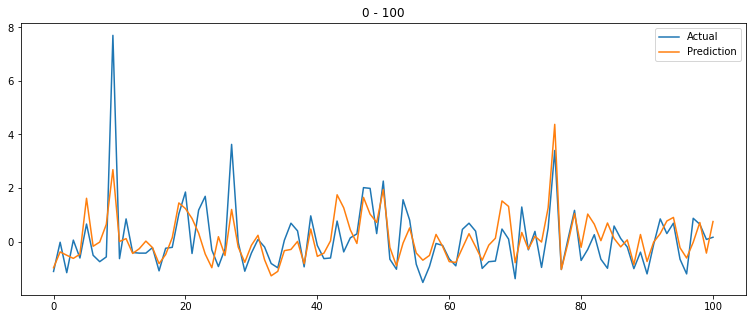

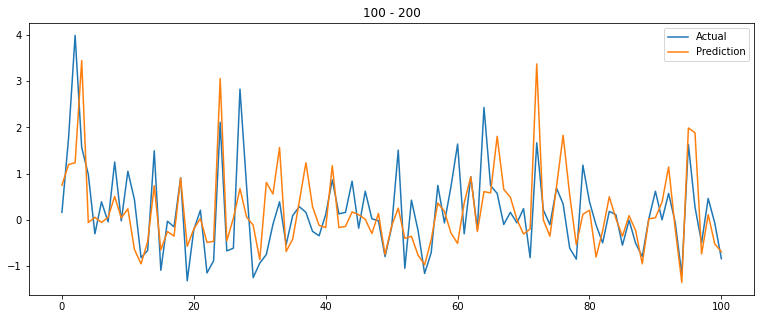

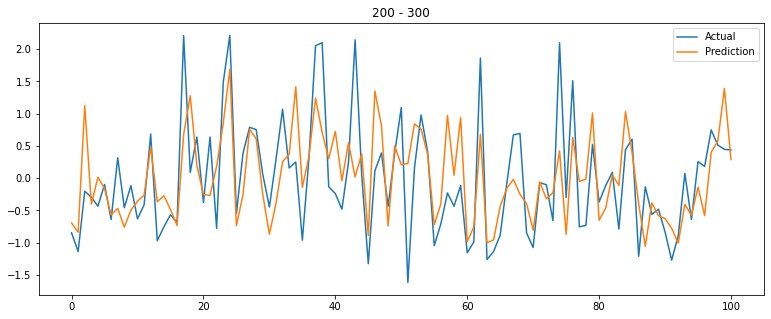

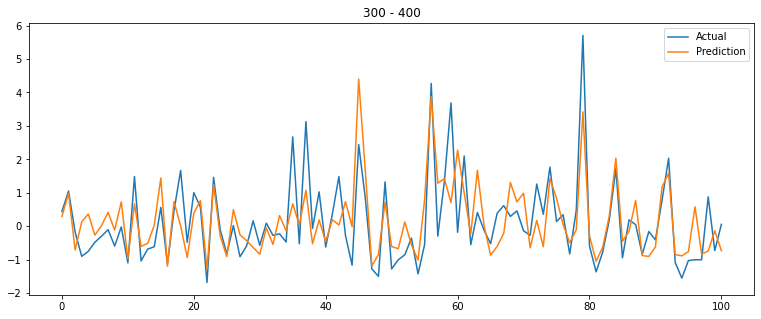

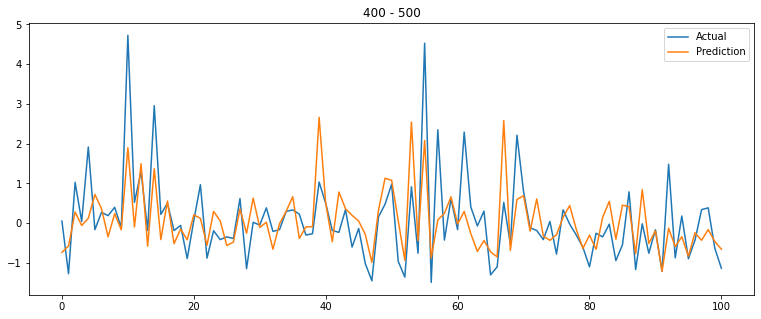

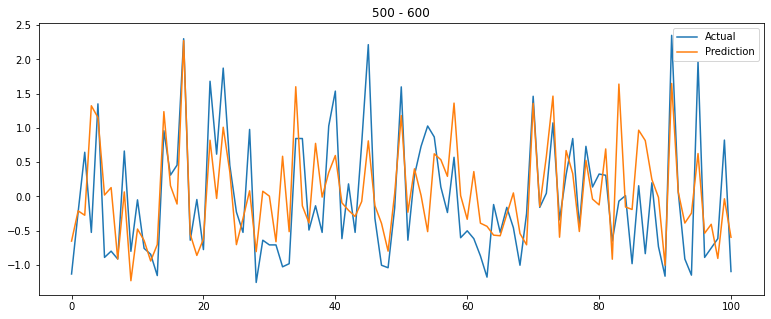

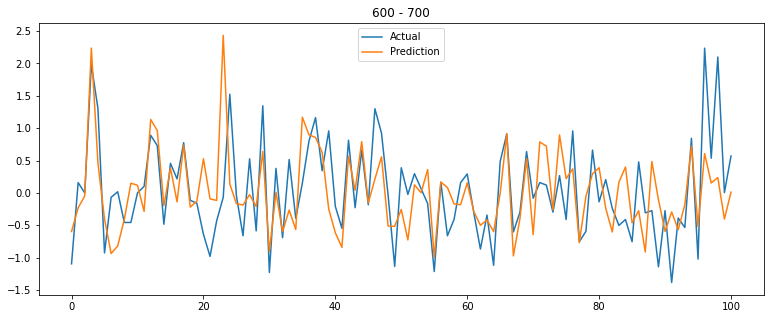

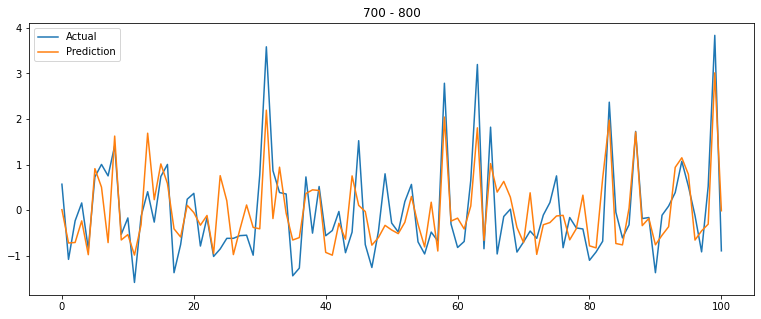

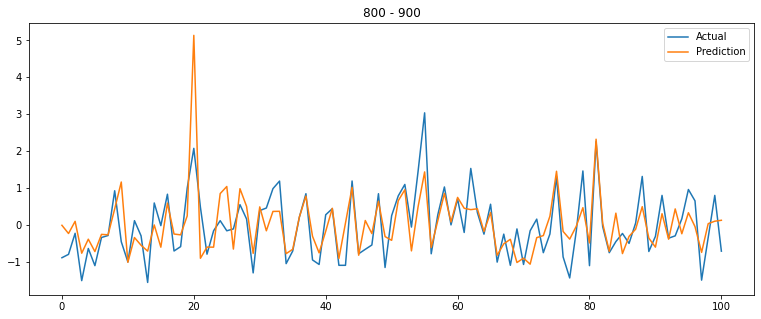

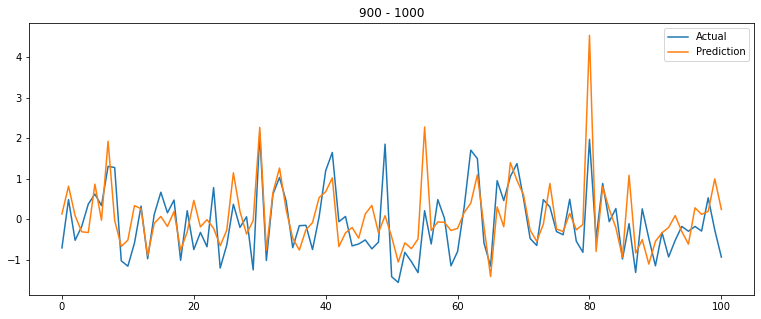

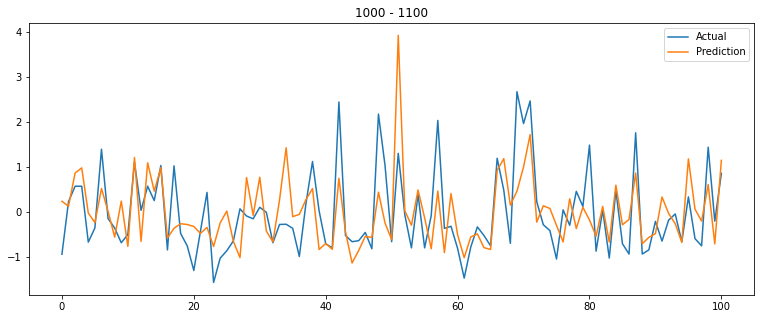

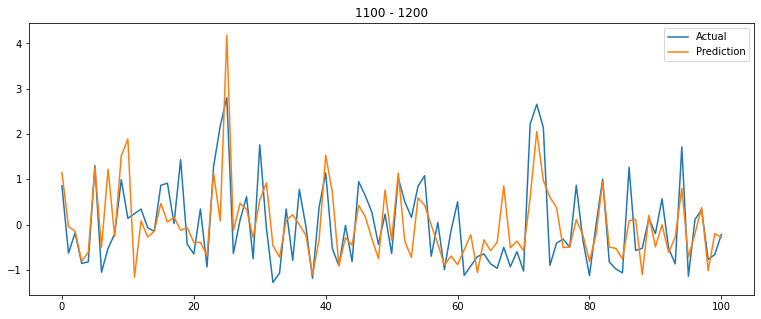

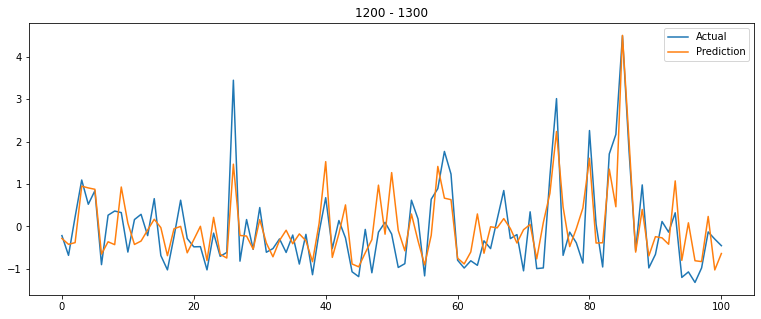

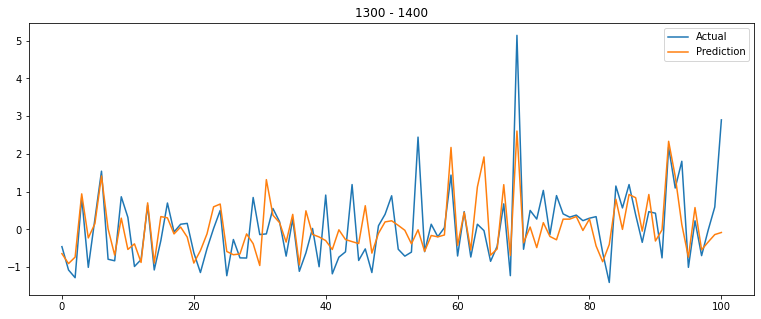

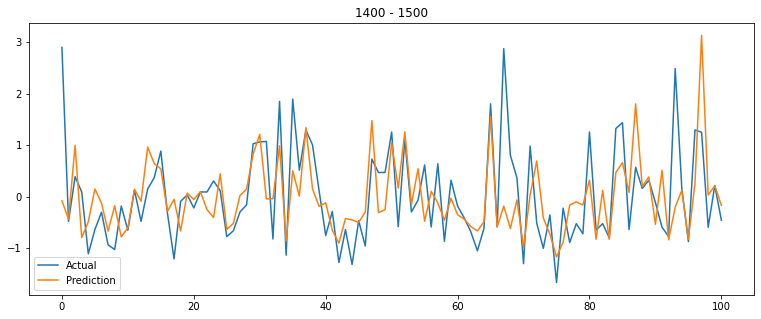

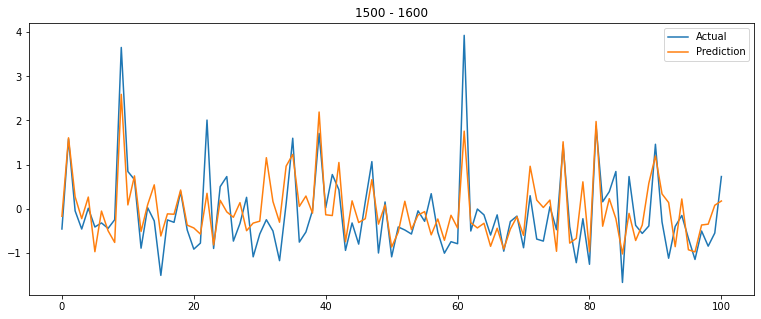

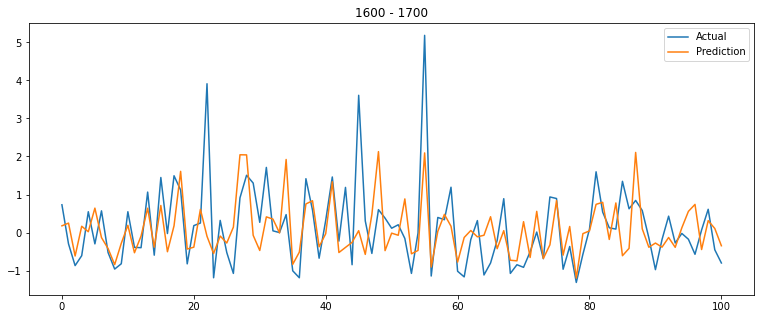

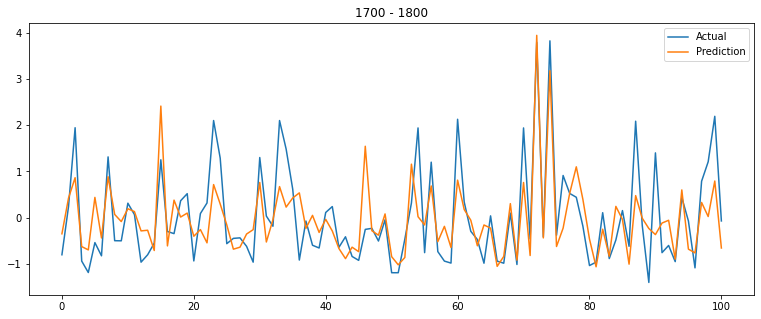

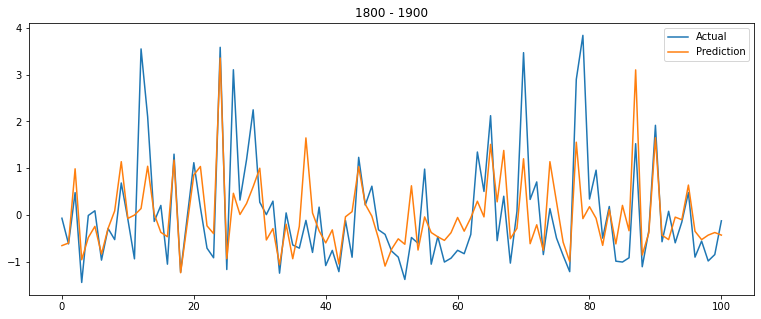

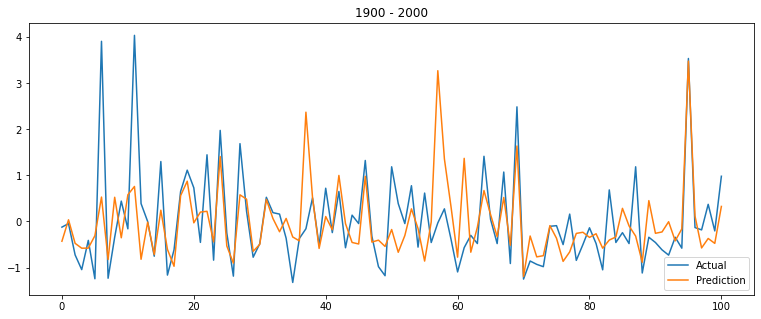

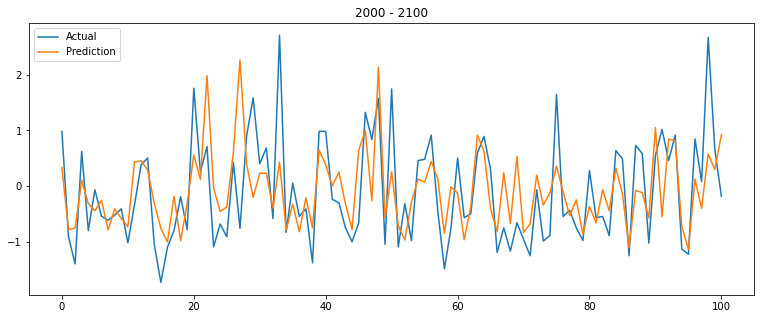

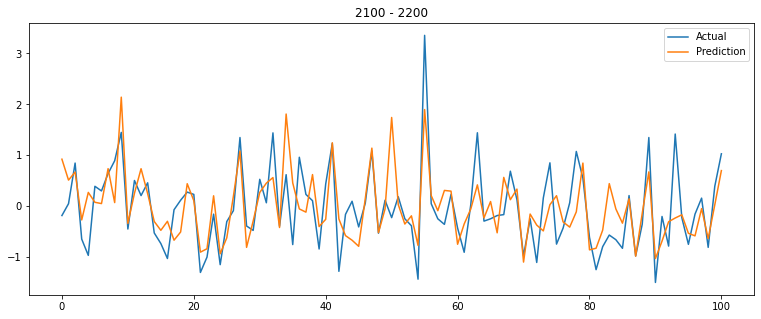

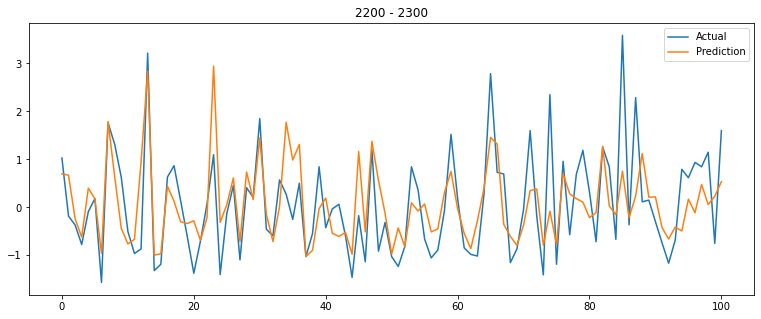

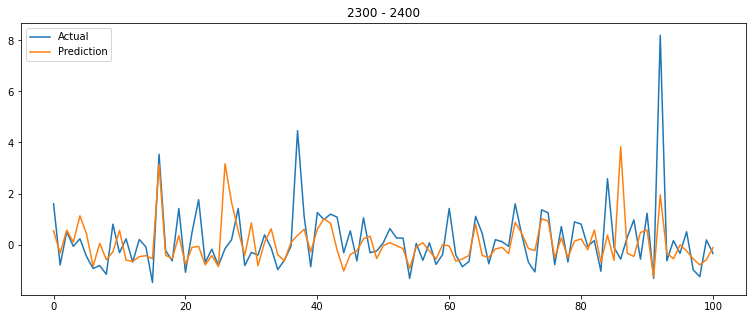

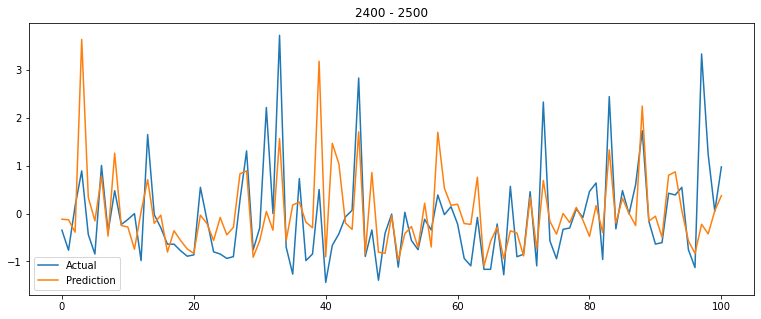

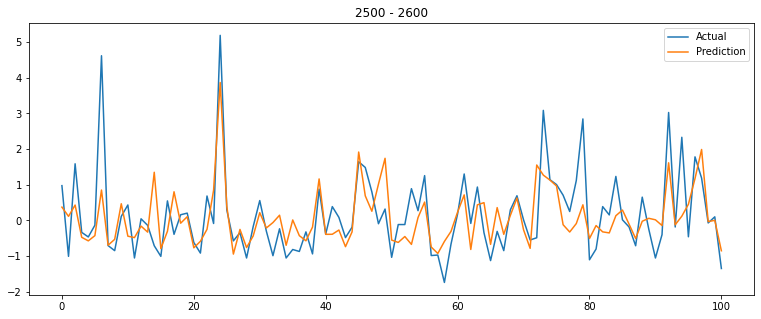

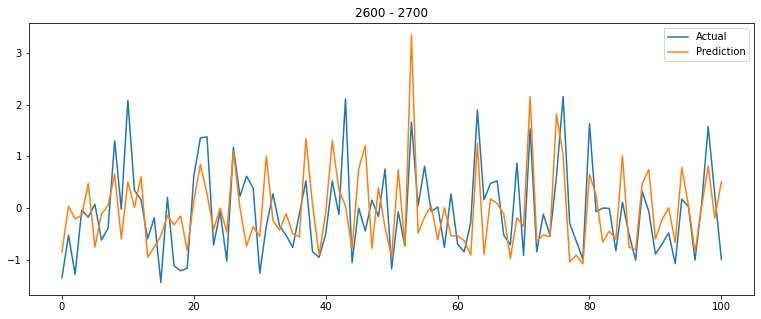

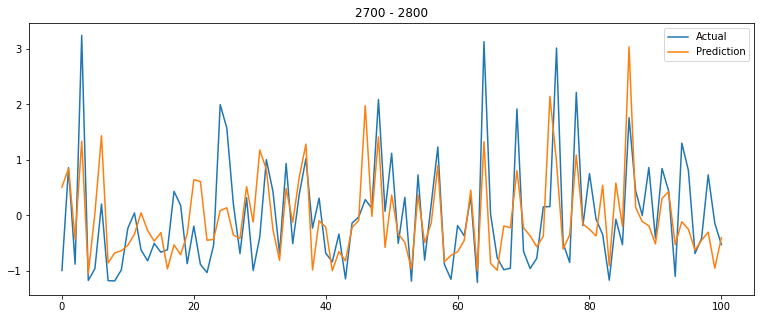

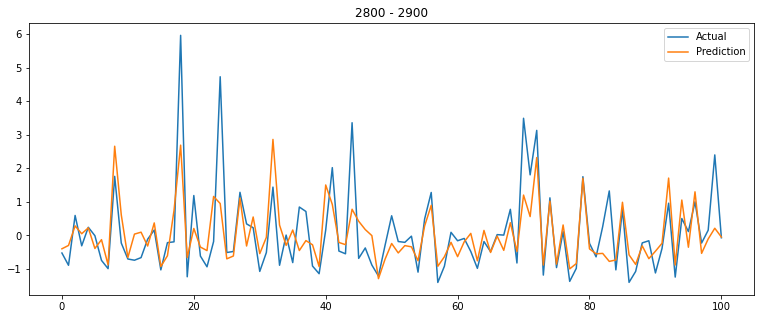

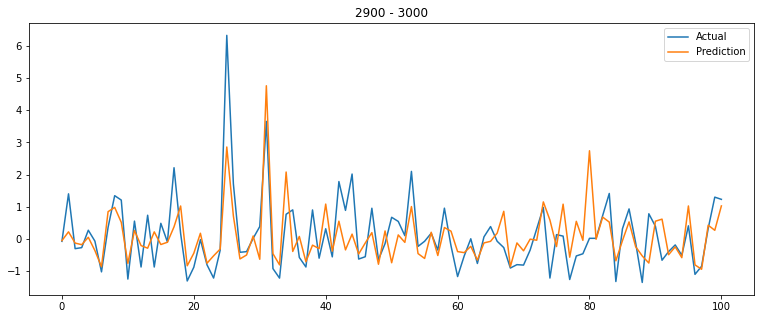

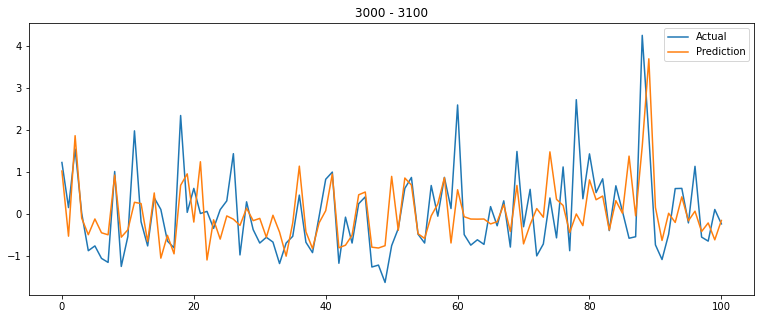

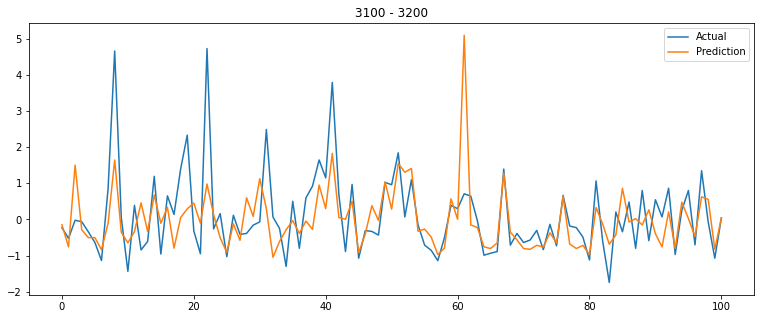

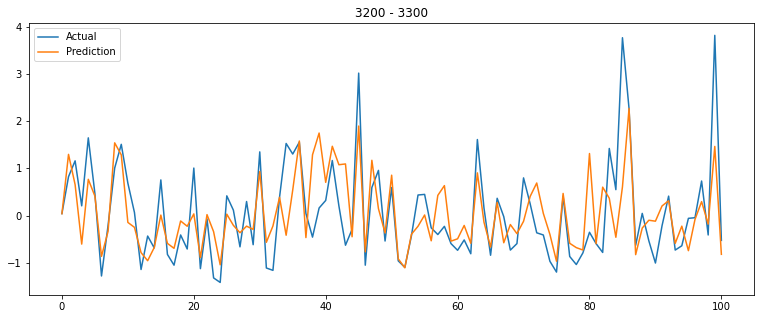

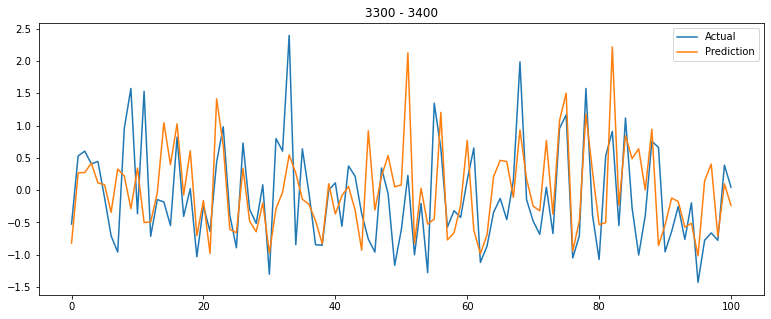

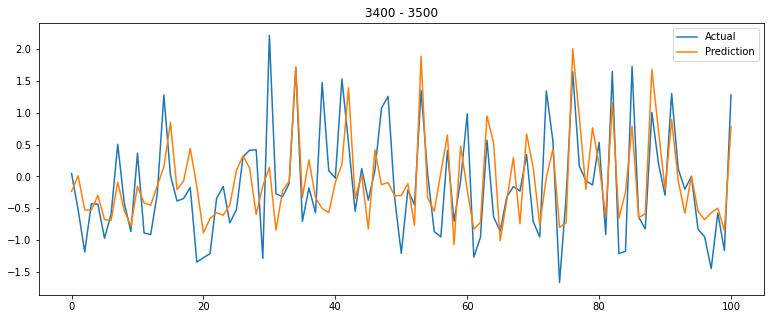

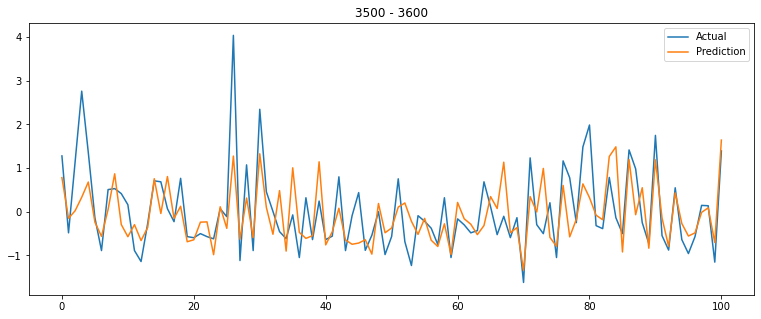

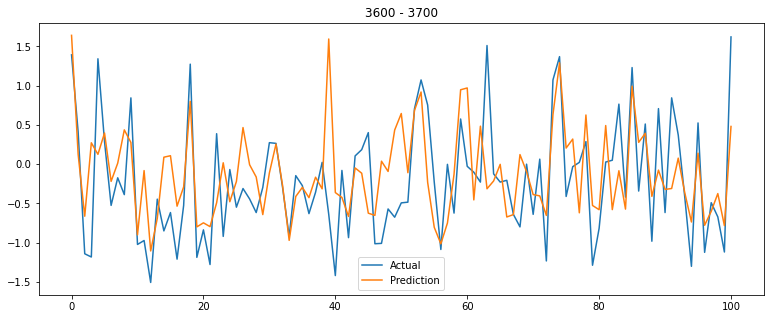

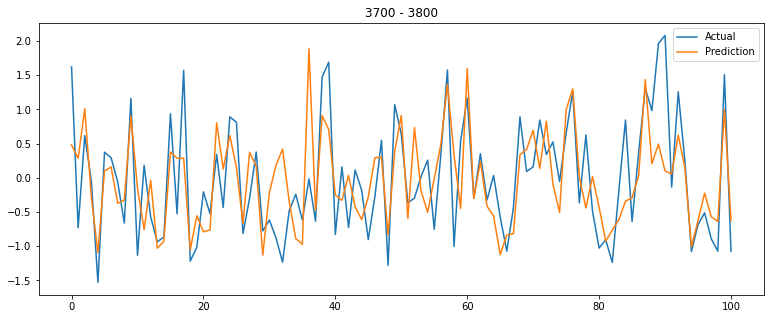

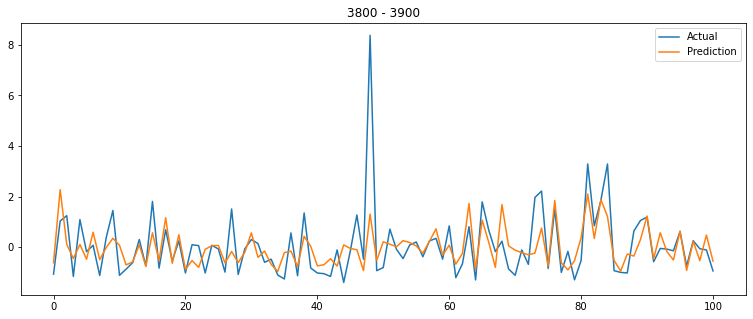

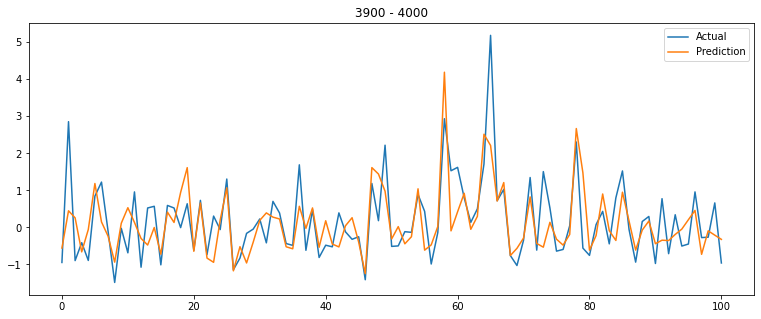

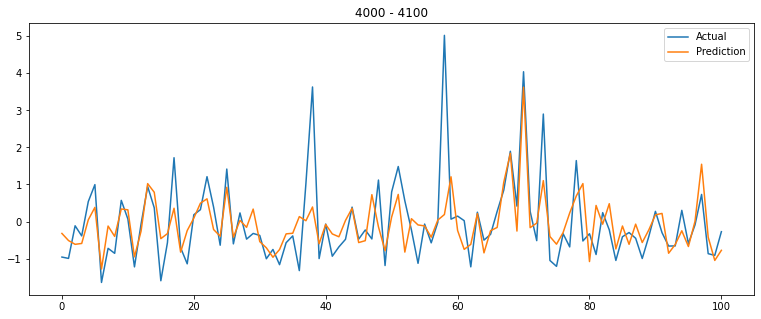

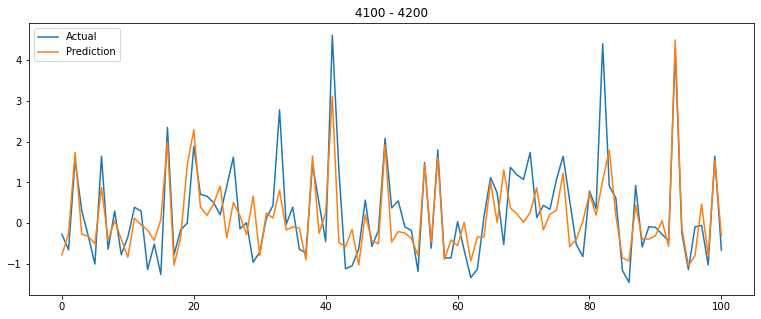

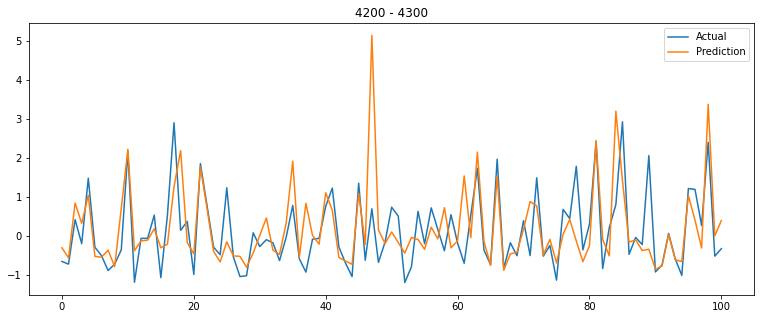

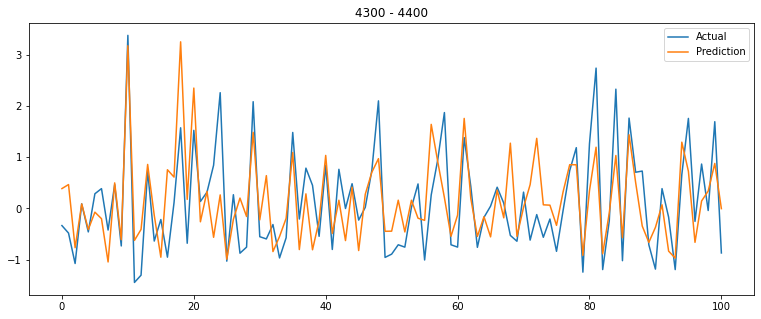

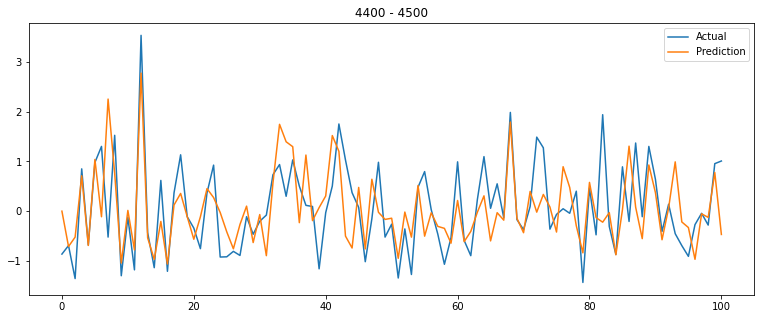

In [38]:
for i in range(0, 4480, 100):
    start = i
    end = start + 100
    plot_result(start, end)

---

I'll wrap things up there. If you want to find some other answers then go ahead `edit` this kernel. If you have any `questions` then do let me know.

If this kernel helped you then don't forget to 🔼 `upvote` and share your 🎙 `feedback` on improvements of the kernel.

![](https://media.giphy.com/media/cp7bUxkodNBHW/giphy.gif)

---